In [1]:
# Always import phasic first to set jax backend correctly
import phasic
import numpy as np
np.random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5, 3.7)
sns.set_context('paper', font_scale=0.9)
# import warnings
# warnings.filterwarnings(action='ignore', category=Warning, module='seaborn')
phasic.set_theme('dark')

In [2]:
from phasic.state_indexing import Property, StateSpace

# Two-Locus Ancestral Recombination Graph (ARG)

This notebook demonstrates the two-locus ARG model using phasic's flexible state indexing system.

The ARG model includes:
- **Coalescence**: Lineages merge, summing descendants at both loci
- **Recombination**: Lineages split, separating descendants by locus

State space tracks:
- `descendants_l1`: Number of descendants at locus 1
- `descendants_l2`: Number of descendants at locus 2

In [3]:
def two_locus_arg(s=None, N=None, R=None):
    """
    Build two-locus ancestral recombination graph (ARG).

    Parameters
    ----------
    s : int
        Sample size
    N : float
        Effective population size (diploid)
    R : float
        Recombination rate between loci

    Returns
    -------
    phasic.Graph
        Phase-type graph representing the ARG
    """

    # Define state space for two-locus model
    state_space = StateSpace([
        Property('descendants_l1', max_value=s),
        Property('descendants_l2', max_value=s)
    ])

    # State vector length
    n = state_space.size

    # Initialize graph
    graph = phasic.Graph(n)

    # Create initial state: s lineages with (1,1) descendants at both loci
    initial_state = np.zeros(n, dtype=int)
    initial_idx = state_space.props_to_index(descendants_l1=1, descendants_l2=1)
    initial_state[initial_idx] = s

    first_vertex = graph.find_or_create_vertex(initial_state)
    graph.starting_vertex().add_edge(first_vertex, 1.0)

    # Process vertices iteratively (graph grows during iteration)
    index = 1
    while index < graph.vertices_length():
        vertex = graph.vertex_at(index)
        state = vertex.state()

        # Count total lineages
        total_lineages = int(np.sum(state))

        if total_lineages <= 1:
            # Only one lineage remaining, stop
            index += 1
            continue

        # Iterate over all lineage configurations
        for i in range(n):
            if state[i] == 0:
                continue

            # Get properties for configuration i
            conf_i = state_space.index_to_props(i)

            # COALESCENCE: Try coalescing with all configurations j >= i
            for j in range(i, n):
                if state[j] == 0:
                    continue

                conf_j = state_space.index_to_props(j)

                # Calculate coalescence rate
                if i == j:
                    if state[i] < 2:
                        continue
                    rate = state[i] * (state[i] - 1) / 2 / N
                else:
                    if state[i] < 1 or state[j] < 1:
                        continue
                    rate = state[i] * state[j] / N

                # Create child state after coalescence
                child_state = state.copy()

                # Remove coalescing lineages
                child_state[i] -= 1
                child_state[j] -= 1

                # Add coalesced lineage (descendants sum at both loci)
                new_l1 = conf_i['descendants_l1'] + conf_j['descendants_l1']
                new_l2 = conf_i['descendants_l2'] + conf_j['descendants_l2']

                # Verify descendants don't exceed sample size
                if new_l1 <= s and new_l2 <= s:
                    k = state_space.props_to_index(descendants_l1=new_l1, descendants_l2=new_l2)
                    child_state[k] += 1

                    child_vertex = graph.find_or_create_vertex(child_state)
                    vertex.add_edge(child_vertex, rate)

            # RECOMBINATION: Can only recombine if lineage has descendants at both loci
            if state[i] > 0 and conf_i['descendants_l1'] > 0 and conf_i['descendants_l2'] > 0:
                rate = R

                # Create child state after recombination
                child_state = state.copy()

                # Remove recombining lineage
                child_state[i] -= 1

                # Add two recombinant lineages (one for each locus)
                k = state_space.props_to_index(descendants_l1=conf_i['descendants_l1'], descendants_l2=0)
                l = state_space.props_to_index(descendants_l1=0, descendants_l2=conf_i['descendants_l2'])
                child_state[k] += 1
                child_state[l] += 1

                child_vertex = graph.find_or_create_vertex(child_state)
                vertex.add_edge(child_vertex, rate)

        index += 1

    return graph

32


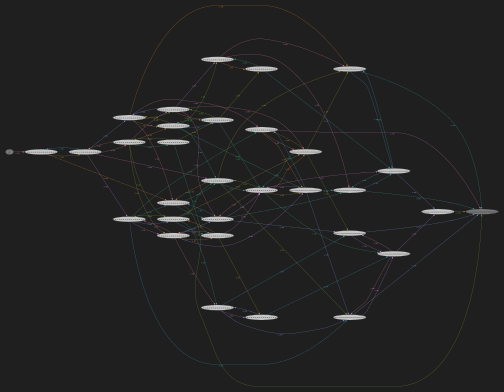

In [6]:
def two_locus_arg(state, s=None, N=None, R=None, state_space=None):

    transitions = []

    if state.sum() <= 1:
        # Only one lineage remaining, stop
        return transitions

    # Iterate over all lineage configurations
    for i in range(state_space.size):
        if state[i] == 0:
            continue

        # Get properties for configuration i
        conf_i = state_space.index_to_props(i)

        # COALESCENCE: Try coalescing with all configurations j >= i
        for j in range(i, state_space.size):
            if state[j] == 0:
                continue

            conf_j = state_space.index_to_props(j)
            # Calculate coalescence rate
            if i == j:
                if state[i] < 2:
                    continue
                rate = state[i] * (state[i] - 1) / 2 / N
            else:
                if state[i] < 1 or state[j] < 1:
                    continue
                rate = state[i] * state[j] / N

            # Create child state after coalescence
            child = state.copy()

            # Remove coalescing lineages
            child[i] -= 1
            child[j] -= 1

            # Add coalesced lineage (descendants sum at both loci)
            new_l1 = conf_i['loc1ton'] + conf_j['loc1ton']
            new_l2 = conf_i['loc2ton'] + conf_j['loc2ton']

            # Verify descendants don't exceed sample size
            if new_l1 <= s and new_l2 <= s:
                k = state_space.props_to_index(loc1ton=new_l1, loc2ton=new_l2)
                child[k] += 1

                transitions.append([child, [rate]])

        # RECOMBINATION: Can only recombine if lineage has descendants at both loci
        if state[i] > 0 and conf_i['loc1ton'] > 0 and conf_i['loc2ton'] > 0:
            rate = R

            # Create child state after recombination
            child = state.copy()

            # Remove recombining lineage
            child[i] -= 1

            # Add two recombinant lineages (one for each locus)
            k = state_space.props_to_index(loc1ton=conf_i['loc1ton'], loc2ton=0)
            l = state_space.props_to_index(loc1ton=0, loc2ton=conf_i['loc2ton'])
            child[k] += 1
            child[l] += 1

            transitions.append([child, [rate]])

    return transitions

nr_samples = 3
# Define state space for two-locus model
state_space = StateSpace([
    Property('loc1ton', max_value=nr_samples),
    Property('loc2ton', max_value=nr_samples)
])

state = np.empty(state_space.size, dtype=int)
state.fill(0)
state[state_space.props_to_index(loc1ton=1, 
                               loc2ton=1)] = nr_samples
ipv = [[state, 1.0]]

graph = phasic.Graph(two_locus_arg, ipv=ipv, 
                     s=nr_samples, N=1, R=1, state_space=state_space)
print(graph.vertices_length())
graph.plot()

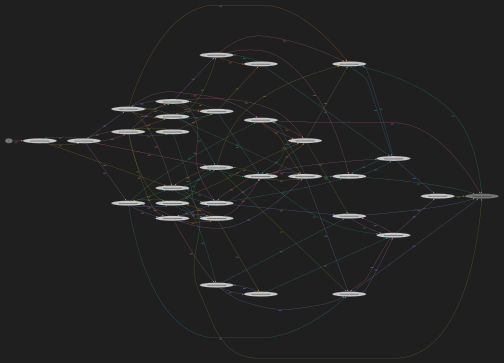

In [5]:
def two_locus_arg(state, s=None, N=None, R=None, state_space=None):

    transitions = []
    if state.sum() <= 1: return transitions

    for i in range(state_space.size):
        if state[i] == 0: continue
        conf_i = state_space.index_to_props(i)

        for j in range(i, state_space.size):
            if state[j] == 0: continue
            conf_j = state_space.index_to_props(j)
            
            same = int(i == j)
            if same and state[i] < 2:
                continue
            if not same and (state[i] < 1 or state[j] < 1):
                continue 
            child = state.copy()
            child[i] -= 1
            child[j] -= 1
            loc1ton = conf_i['loc1ton'] + conf_j['loc1ton']
            loc2ton = conf_i['loc2ton'] + conf_j['loc2ton']
            if loc1ton <= s and loc1ton <= s:
                child[state_space.props_to_index(loc1ton=loc1ton, loc2ton=loc2ton)] += 1
                transitions.append([child, [state[i]*(state[j]-same)/(1+same)]])

        if state[i] > 0 and conf_i['loc1ton'] > 0 and conf_i['loc2ton'] > 0:
            child = state.copy()
            child[i] -= 1
            child[state_space.props_to_index(loc1ton=conf_i['loc1ton'], loc2ton=0)] += 1
            child[state_space.props_to_index(loc1ton=0, loc2ton=conf_i['loc2ton'])] += 1
            transitions.append([child, [R]])

    return transitions


nr_samples = 3
state_space = StateSpace([
    Property('loc1ton', max_value=nr_samples),
    Property('loc2ton', max_value=nr_samples)
])

initial = np.empty(state_space.size+2, dtype=int)
initial.fill(0)
initial[state_space.props_to_index(loc1ton=1, loc2ton=1)] = nr_samples
ipv = [[initial, 1.0]]
graph = phasic.Graph(two_locus_arg, ipv=ipv, s=nr_samples, N=1, R=1, state_space=state_space)
graph.plot()

In [10]:
phasic.clear_caches()

Cache directory does not exist: /Users/kmt/.jax_cache
Clearing cache at /Users/kmt/.phasic_cache
  Files: 5
  Size: 345.4 MB
Cache directory does not exist: /Users/kmt/.phasic_traces


In [7]:

import time

# for nr_samples in [7]:
for nr_samples in range(3, 9):
    print(nr_samples)
    state_space = StateSpace([
        Property('loc1ton', max_value=nr_samples),
        Property('loc2ton', max_value=nr_samples)
    ])
    start = time.time()
    initial = np.empty(state_space.size+2, dtype=int)
    initial.fill(0)
    initial[state_space.props_to_index(loc1ton=1, loc2ton=1)] = nr_samples
    ipv = [[initial, 1.0]]
    graph = phasic.Graph(two_locus_arg, ipv=ipv, s=nr_samples, N=1, R=1, state_space=state_space)
    print("construction:", time.time() - start)

    start = time.time()
    graph.compute_trace(hierarchical=True)
    print("first trace:", time.time() - start)

    start = time.time()
    graph.compute_trace(hierarchical=True)
    print("second trace:", time.time() - start)




3
construction: 0.0032501220703125
first trace: 0.04892420768737793
second trace: 0.0015730857849121094
4
construction: 0.008028030395507812
first trace: 0.4393899440765381
second trace: 0.009172201156616211
5
construction: 0.031100034713745117
first trace: 0.7574138641357422
second trace: 0.14797091484069824
6
construction: 0.13544178009033203
first trace: 5.057930946350098
second trace: 1.1462101936340332
7


[WARNING] phasic.hierarchical_trace_cache: Graph has 226 small SCCs (<50 vertices) that will be included in large SCC subgraphs
[WARNING] phasic.hierarchical_trace_cache: This may reduce cache reuse. Consider increasing min_size to avoid subdivision.


construction: 0.5030198097229004


: 

## Example: Build and Visualize ARG

In [ ]:
# Build ARG for small sample
graph = two_locus_arg(s=4, N=1000, R=1)

print(f"Graph has {graph.vertices_length()} vertices")
print(f"Sample size: 4, Population size: 1000, Recombination rate: 1")

In [ ]:
# Visualize the graph (limited to 200 nodes for clarity)
graph.plot(max_nodes=200)

## Analysis

Compute moments and distributions for the ARG.

In [ ]:
# Expected time to most recent common ancestor (TMRCA)
tmrca_expectation = graph.phase_type_moment(1)
print(f"Expected TMRCA: {tmrca_expectation:.4f}")

# Variance
second_moment = graph.phase_type_moment(2)
variance = second_moment - tmrca_expectation**2
print(f"Variance: {variance:.4f}")

In [ ]:
# Plot TMRCA distribution
times = np.linspace(0, tmrca_expectation * 3, 100)
pdf = graph.pdf(times)

plt.figure(figsize=(8, 5))
plt.plot(times, pdf, linewidth=2)
plt.axvline(tmrca_expectation, color='r', linestyle='--', label=f'E[T] = {tmrca_expectation:.2f}')
plt.xlabel('Time')
plt.ylabel('Probability density')
plt.title('TMRCA Distribution for Two-Locus ARG')
plt.legend()
plt.tight_layout()
sns.despine()
plt.show()

## Effect of Recombination Rate

Compare ARGs with different recombination rates.

In [ ]:
# Build graphs with different recombination rates
recomb_rates = [0.1, 1.0, 10.0]
results = []

for R in recomb_rates:
    g = two_locus_arg(s=3, N=1000, R=R)
    exp_t = g.phase_type_moment(1)
    results.append({
        'R': R,
        'vertices': g.vertices_length(),
        'E[TMRCA]': exp_t
    })

df = pd.DataFrame(results)
print("\nEffect of recombination rate:")
print(df.to_string(index=False))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot graph size
axes[0].plot(df['R'], df['vertices'], marker='o', linewidth=2)
axes[0].set_xlabel('Recombination rate')
axes[0].set_ylabel('Number of vertices')
axes[0].set_title('Graph Complexity vs Recombination')
axes[0].set_xscale('log')

# Plot expected TMRCA
axes[1].plot(df['R'], df['E[TMRCA]'], marker='o', linewidth=2, color='C1')
axes[1].set_xlabel('Recombination rate')
axes[1].set_ylabel('E[TMRCA]')
axes[1].set_title('Expected TMRCA vs Recombination')
axes[1].set_xscale('log')

plt.tight_layout()
sns.despine()
plt.show()

## Summary

This notebook demonstrates:
- Two-locus ARG construction using flexible state indexing
- Coalescence events that merge lineages at both loci
- Recombination events that split lineages by locus
- TMRCA distribution computation
- Effect of recombination rate on graph complexity

**Key observations:**
- Higher recombination rates increase graph complexity (more vertices)
- Recombination affects the TMRCA distribution
- The flexible state indexing system handles arbitrary property combinations